# Housekeeping

In [30]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [31]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import set_config
import re
import json

# Machine Learning - Models
from xgboost import XGBRegressor, DMatrix

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import set_global_seeds, MASTER_SEED
from functions import plot_residuals_analysis, plot_model_comparison_heatmap
from functions import plot_prediction_intervals, plot_learning_curves

## Settings

In [32]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Import of variables from previous notebooks



In [33]:
with open('processed_data/model_results.json', 'r') as f:
    model_results = json.load(f)

%store -r X_train_genus
%store -r X_test_genus
%store -r Y_train
%store -r Y_test

#  Comparison of models

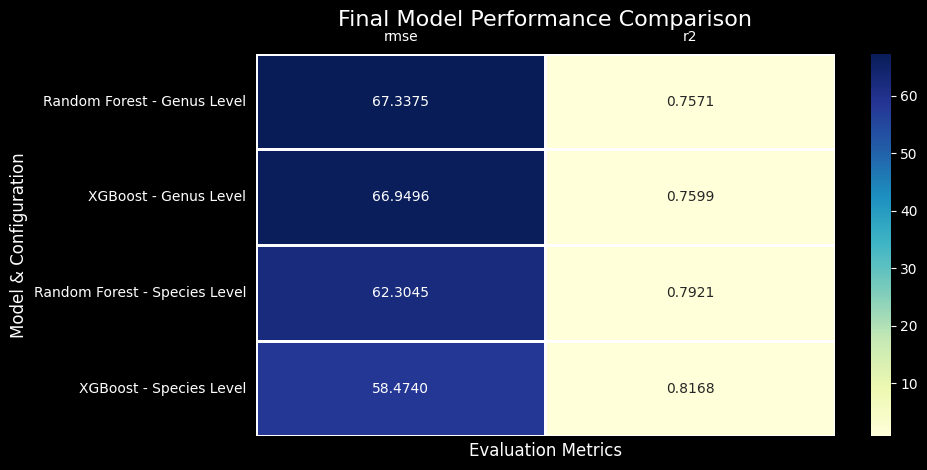

In [34]:
plot_model_comparison_heatmap(model_results, title="Final Model Performance Comparison")

## Base Visualisations

### Training the best model

In [35]:
xgb_params = model_results[1]['best_params']
best_xgb = XGBRegressor(
    **xgb_params,
    objective='reg:squarederror',
    random_state=MASTER_SEED,
    n_jobs=-1
)

best_xgb.fit(X_train_genus, Y_train)
yhat_best = best_xgb.predict(X_test_genus)

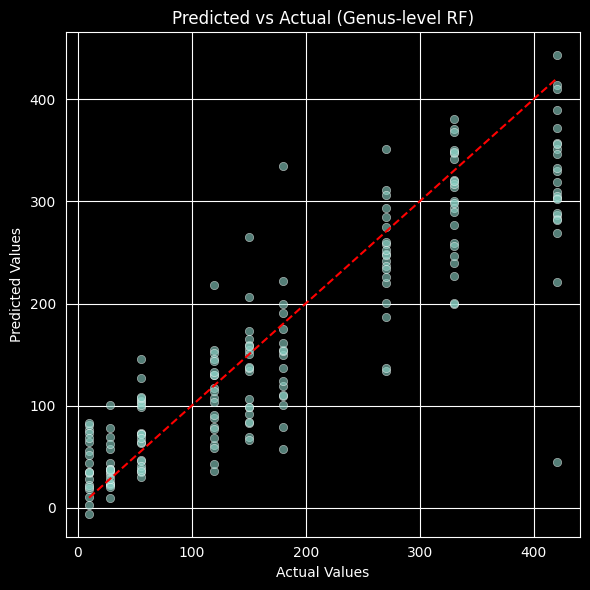

In [36]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_best, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

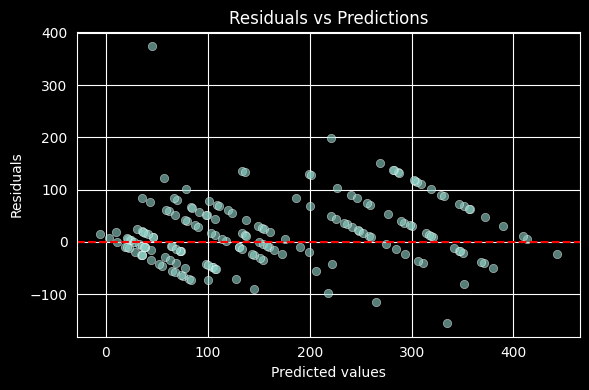

In [37]:
residuals = Y_test - yhat_best

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat_best, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

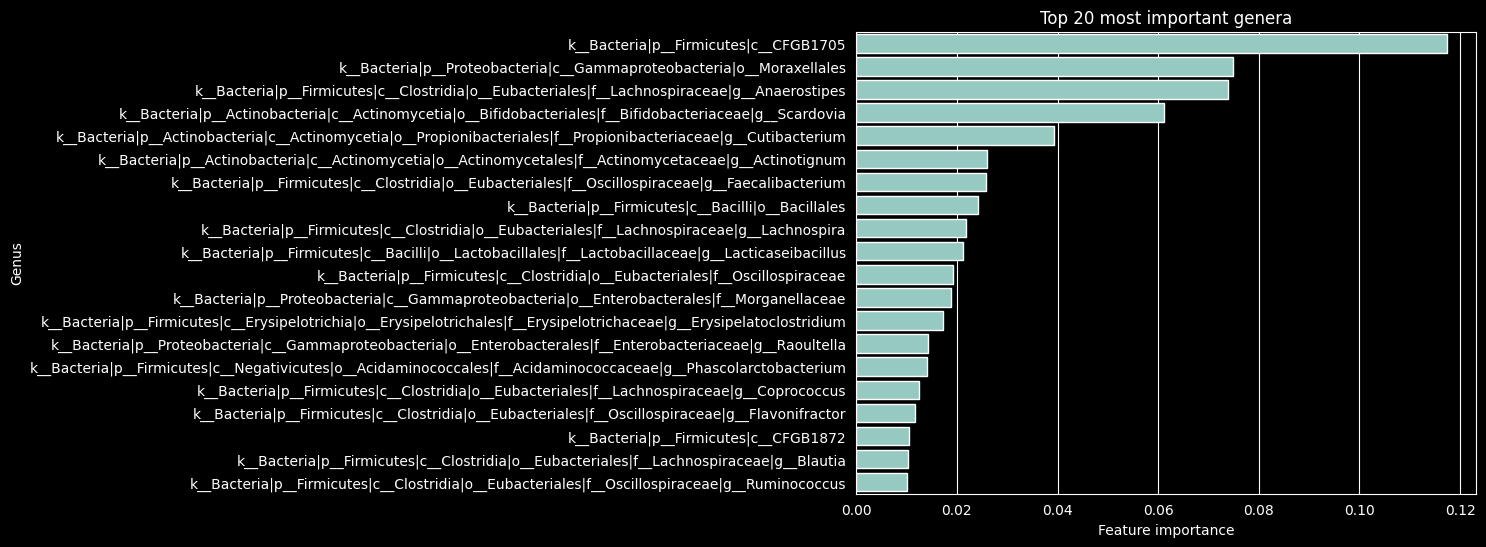

In [38]:
importances = pd.Series(
    best_xgb.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [39]:
#Get the column names from your training dataframe
feature_names = X_train_genus.columns.tolist()

#Inject the coloumn names into the booster object inside your model
best_xgb.get_booster().feature_names = feature_names

st = SuperTree(
    best_xgb,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

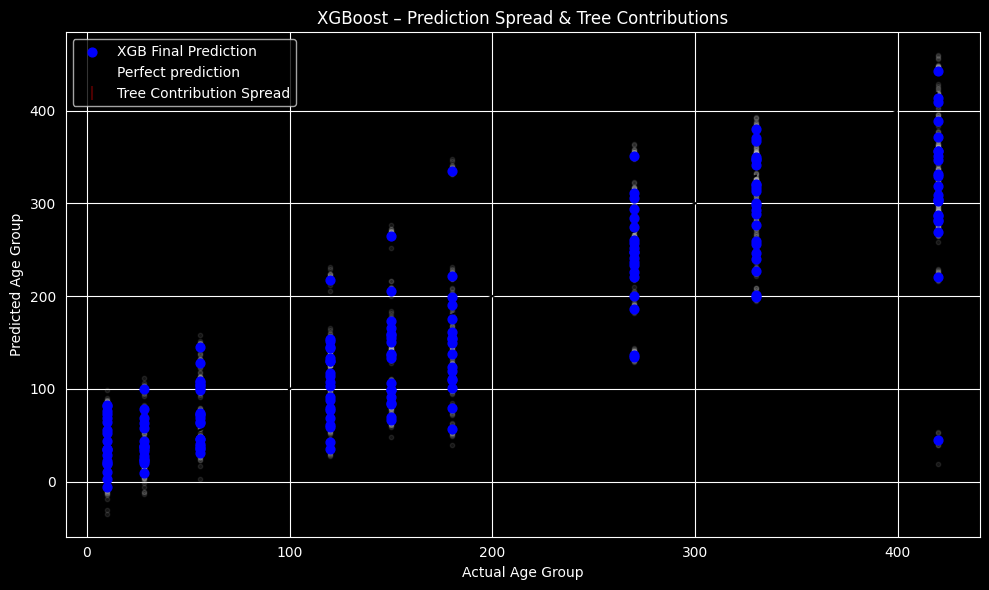

In [42]:
#Syncing the model's expectations with the actual DataFrame columns
best_xgb.get_booster().feature_names = X_test_genus.columns.tolist()

#Get individual tree contributions
booster = best_xgb.get_booster()
booster.feature_names = feature_names

#Producing an array of shape (n_samples, n_trees)
#Each column is the specific value added by THAT tree.
contribs = booster.predict(
    DMatrix(X_test_genus, feature_names=feature_names),
    pred_contribs=True,
    validate_features=True
)

#Derive everything from the forest
bias = contribs[:, -1]
tree_contributions = contribs[:, :-1]

#Calculating the final prediction
xgb_pred = contribs.sum(axis=1)

#Calculating standard deviation of the contributions to show variance/importance
xgb_std = tree_contributions.std(axis=1)

# --- Plotting ---
plt.figure(figsize=(10,6))

#Plot the "spread" of tree contributions around the final prediction, centering the contributions around the mean prediction for visualization
for i in range(num_trees):
    #Showing a subset of trees if there are too many (e.g., first 50) to keep it fast
    if i < 50:
        plt.scatter(Y_test, xgb_pred + tree_contributions[:, i], color='lightgray', alpha=0.1, s=10)

#Plot XGBoost final prediction
plt.scatter(Y_test, xgb_pred, color='blue', label='XGB Final Prediction', s=40, zorder=5)

#Plot Error bars (uncertainty based on tree variance)
plt.errorbar(Y_test, xgb_pred, yerr=xgb_std, fmt='none', color='red', alpha=0.3, label='Tree Contribution Spread')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("XGBoost – Prediction Spread & Tree Contributions")
plt.legend()
plt.tight_layout()
plt.show()

## Advanced Visualisations

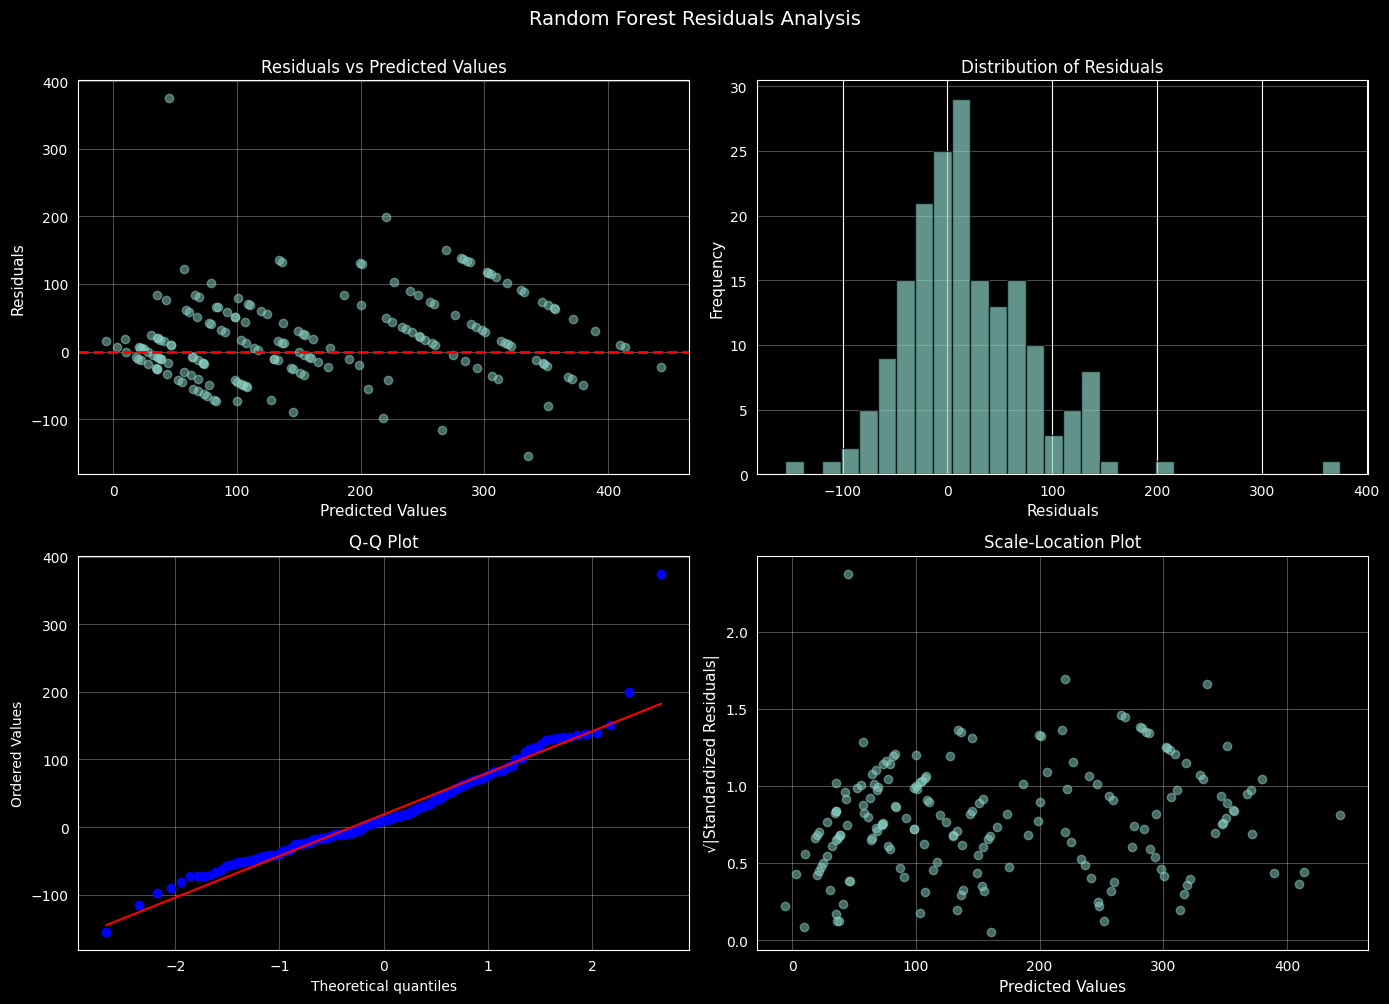


Residual Statistics:
  Mean: 18.6970
  Std Dev: 63.0249
  Min: -154.8960
  Max: 374.7696
  MAE: 47.2863


In [43]:
plot_residuals_analysis(Y_test, yhat_best, title="Random Forest Residuals Analysis")

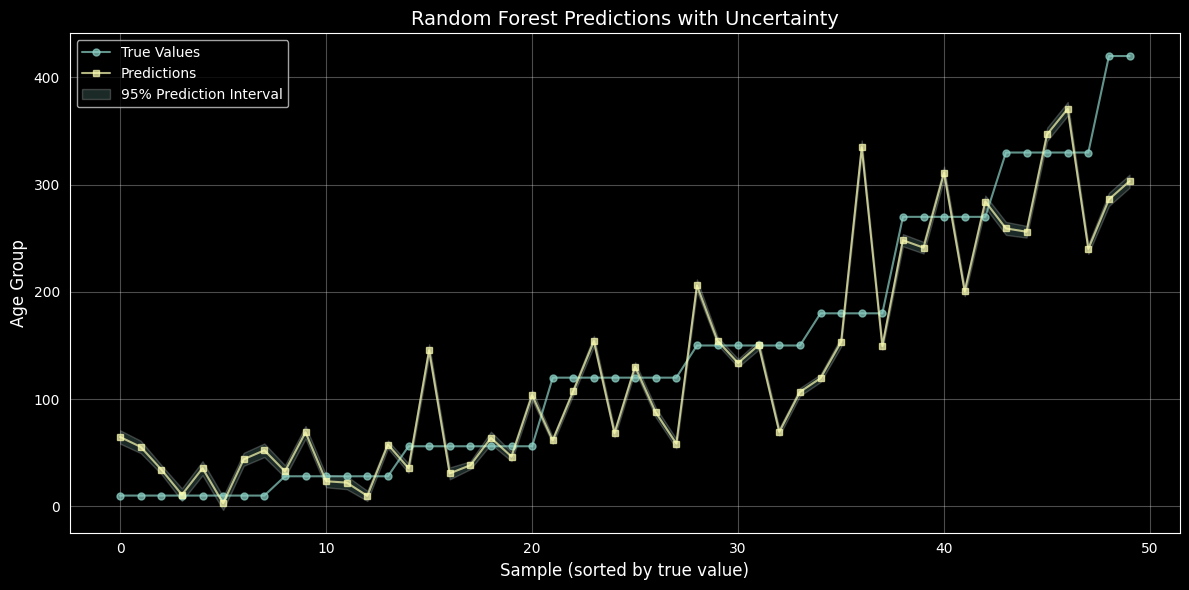

In [44]:
# Prediction intervals (showing uncertainty from individual trees)
plot_prediction_intervals(
    Y_test,
    yhat_best,
    prediction_std=xgb_std,
    sample_indices=range(50),  # Show first 50 samples
    title="Random Forest Predictions with Uncertainty"
)

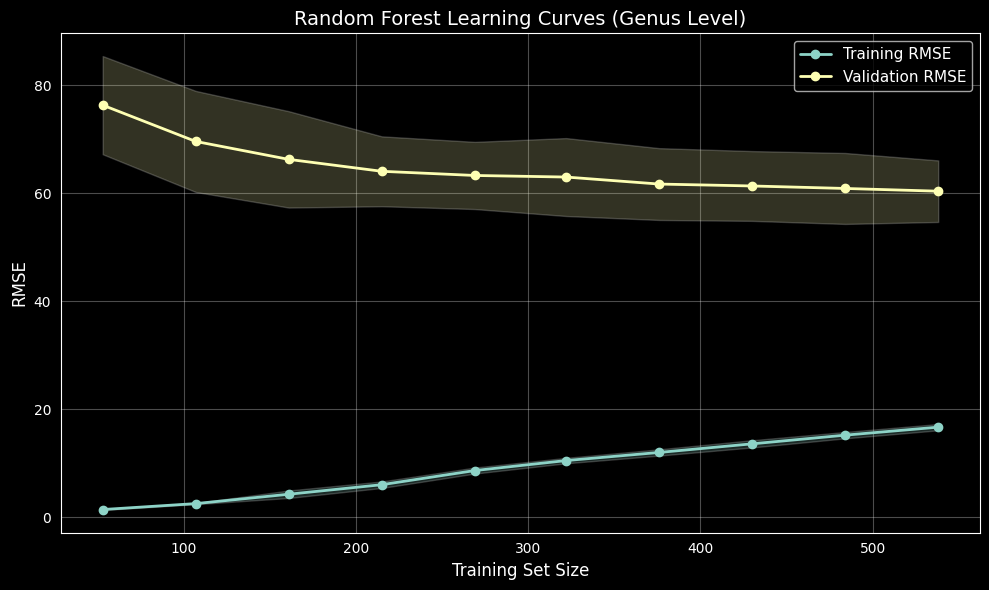

In [45]:
# Learning curves to check for overfitting

plot_learning_curves(
    best_xgb,
    X_train_genus,
    Y_train,
    cv_folds=7,
    title="Random Forest Learning Curves (Genus Level)"
)

In [46]:
#Cleaning up RAM by removing the stored variables

#del X_train_genus
#del X_test_genus
#del Y_train
#del Y_test